<a href="https://www.kaggle.com/code/nicolaorlandowork/spaceship-titanic-everything-all-at-once?scriptVersionId=120394767" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Introduction 

Notebook for the challenge spaceship Titanic: https://www.kaggle.com/competitions/spaceship-titanic/overview.
The final score on the Kaggle submission file is 0.80289, top 20% of the leaderboard. Not bad given how simplistic this notebook is. 

The github repositiory wiht the code is here https://github.com/nicola-orlando/spaceship-titanic. Happy reading 😃 !

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current sessionssaa

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# **Libraries and functions**

Here importing the python modules to be used later on. These will include the model to be used for the challenge, XGBoost. 

In [2]:
from pandas import read_csv

# Basic plots
import matplotlib.pyplot as plt
import seaborn as sn

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split

# Options to run the notebook and data

Here I define a list of options to use to run the notebook and I load the data to be used. Note that I create a few copies of the dataset for later convenience. **This code fragment can be changed as needed to test multiple setups. A summary of the results is in the last section of the notebook**

In [3]:
drop_nans = True 
fill_nans_with_average = False 
fill_nans_with_zeros = True 
remove_outliers = False
dummy_optimisation = True
feature_importance_plot = False
variables_to_drop_training = ['PassengerId', 'Num', 'Cabin', 'Group', 'Vowels', 'Consonant'] # Spoiler ! 

# Data to be manipulated 
data = read_csv('/kaggle/input/spaceship-titanic/train.csv')
# Data, just to be used for plotting, e.g. categorical data is unconverted 
data_orig = read_csv('/kaggle/input/spaceship-titanic/train.csv')
# Data for testing 
data_test = read_csv('/kaggle/input/spaceship-titanic/test.csv')
# Data for submission
data_sub = read_csv('/kaggle/input/spaceship-titanic/test.csv')

# EDA and features selection 

Here I perform a number of checks and try to extract further training features from the dataset. In order I will look at 

1. Distribution of the NaNs
2. Feature selection 
3. Investigate the presence of outliers and cap them out of the training data (option switched off by default)

### NaNs 

There are two set of information I want to extract at this step

1. How many NaNs are in each column 
2. For a selection of features (here I focus on the target label and numerical features) check their average values for cases where a given other feature is a NaN or not. That is, is the underlying population distribution different for NaNs and not NaNs? This is mostly a quick check and I didn't investigate this in great detail as I eventually didn't take any specific action

Let's start with a simple global counting 

Looking at the distribution of the NaNs
Column PassengerId has 0 nans
Column HomePlanet has 201 nans
Column CryoSleep has 217 nans
Column Cabin has 199 nans
Column Destination has 182 nans
Column Age has 179 nans
Column VIP has 203 nans
Column RoomService has 181 nans
Column FoodCourt has 183 nans
Column ShoppingMall has 208 nans
Column Spa has 183 nans
Column VRDeck has 188 nans
Column Name has 200 nans
Column Transported has 0 nans


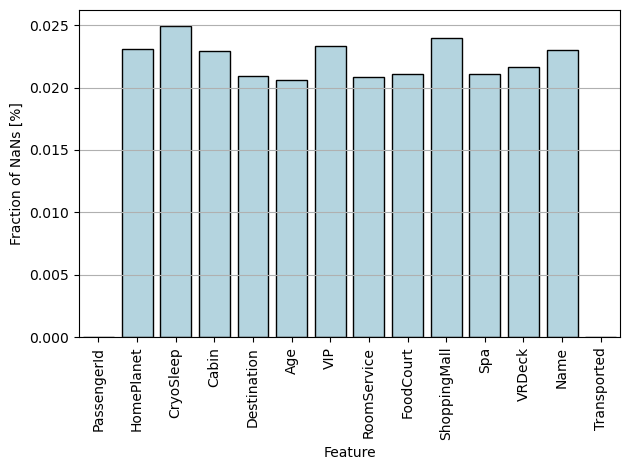

In [4]:
# ------------------------------------------- Analysis of the NaNs

# Count how many nans there are in each column
# For training dataset only we do a plot of the fraction of NaNs and look for aggregate data over average target label for NaNs or not NaNs 
nans_fractions = []
print('Looking at the distribution of the NaNs')

# NaNs summary
for column in data.columns:
    num_of_nans = data[column].isna().sum()
    nans_fractions.append(num_of_nans/len(data))
    print('Column '+str(column)+' has '+str(num_of_nans)+' nans')

def plot_nans_summary(nans):
    fig = plt.figure()
    ax = sn.barplot(x=data.columns, y=nans, color='lightblue', edgecolor='black')
    ax.set(xlabel='Feature', ylabel='Fraction of NaNs [%]')
    plt.xticks(rotation=90)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig('nans_distribution.png')
        
plot_nans_summary(nans_fractions)

Great, we see that the columns in the data have typically below 25% NaNs, so nothing has to be removed a priori (e.g., a feature with 90% NaNs would hardly be useful). 

Now let's summarise in plots the information of the second point above. **These plots are specifically hard to read, so may be skipped without much information loss**

<Figure size 640x480 with 0 Axes>

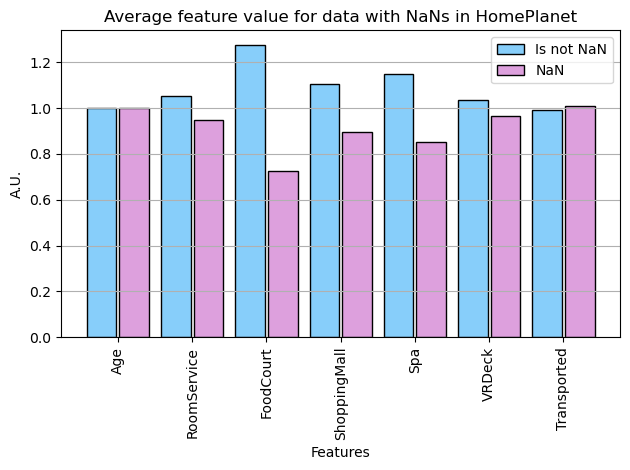

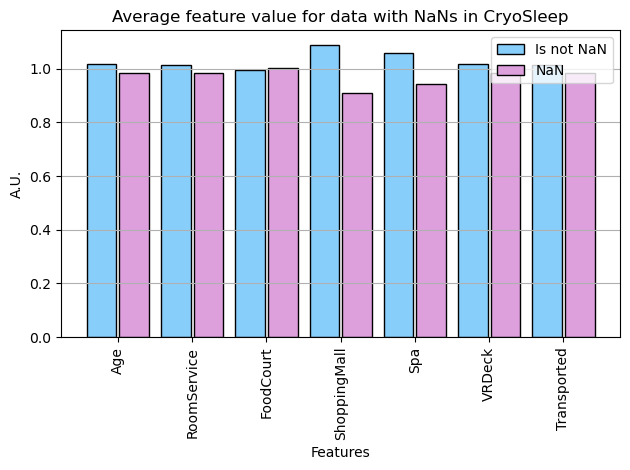

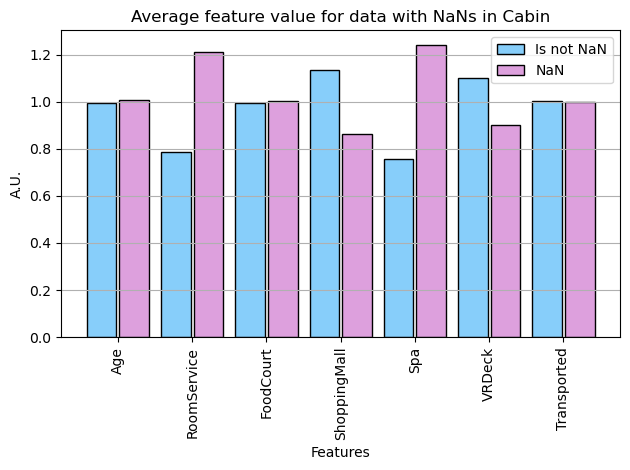

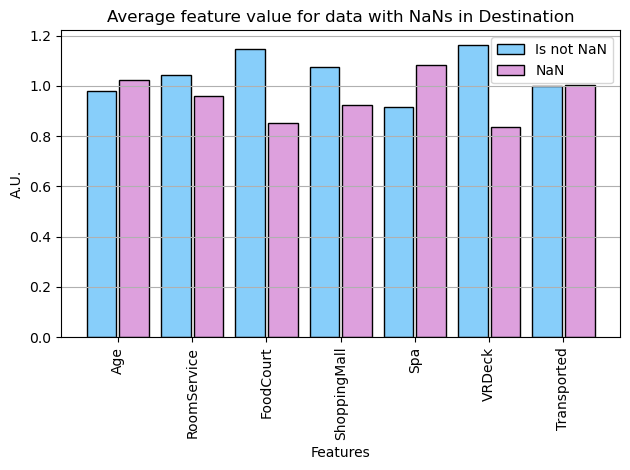

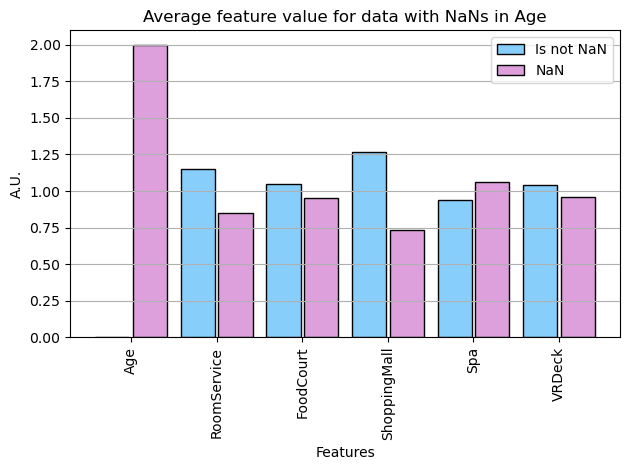

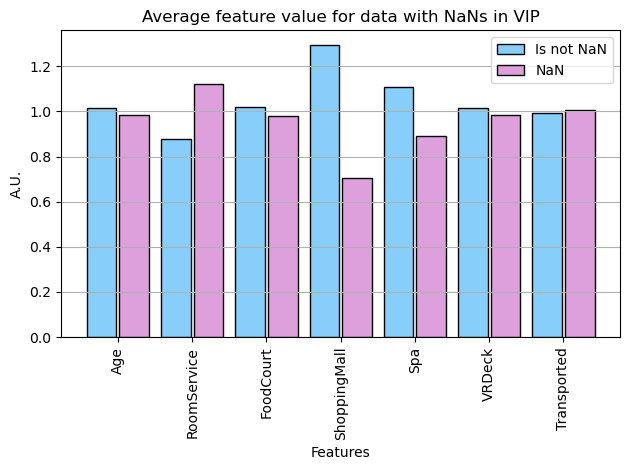

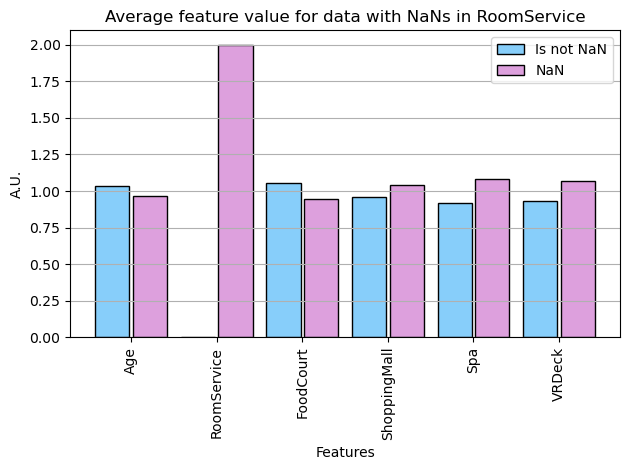

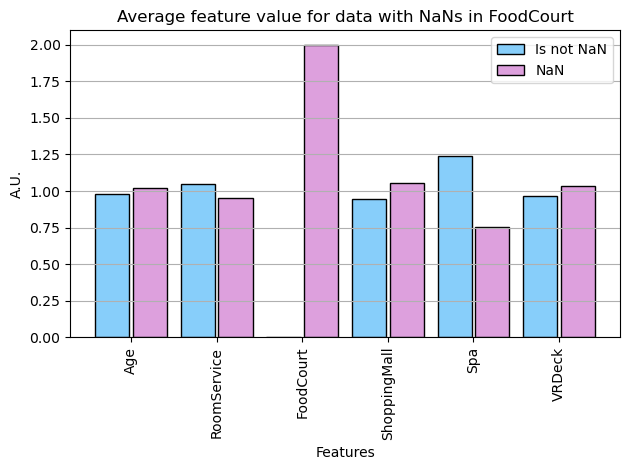

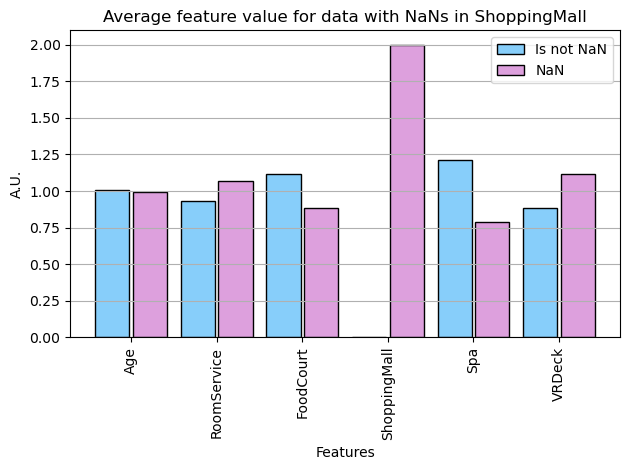

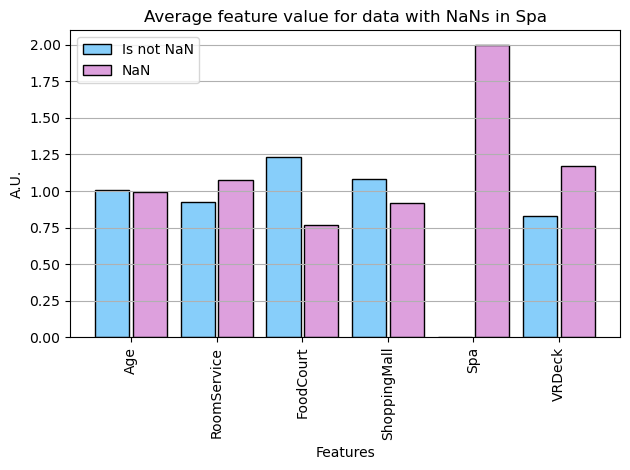

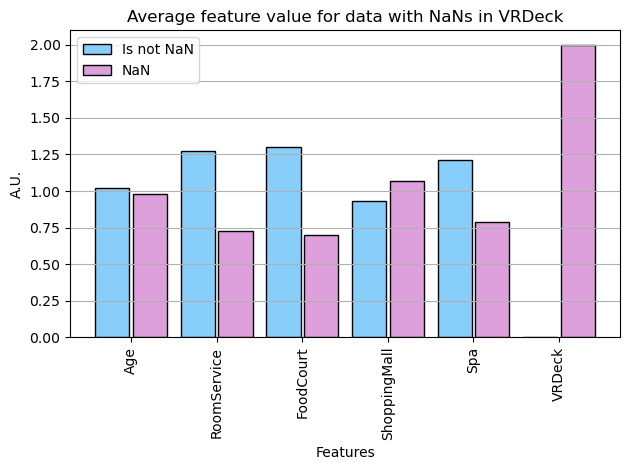

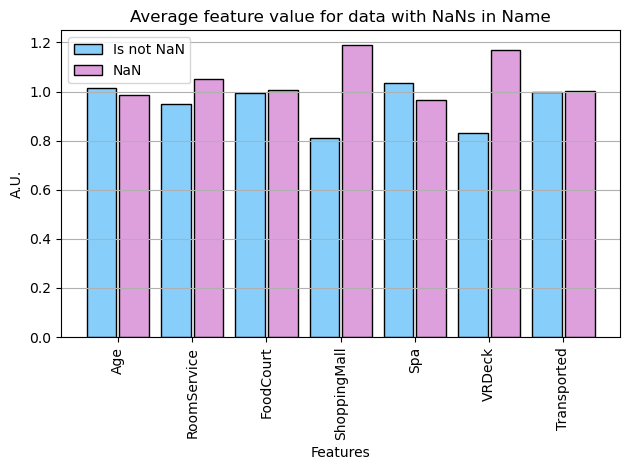

<Figure size 640x480 with 0 Axes>

In [5]:
def plot_nans_agg_data_individual(data):

    for column in data.columns:

        fig = plt.figure()
        num_of_nans = data[column].isna().sum()
        if num_of_nans > 0 :
            columns_to_plot = data.columns
            data_agg = data.groupby(data[column].isnull(), as_index = False).mean(numeric_only=True)
            data_agg[column] = data_agg.index
            # Remove aggregation label with the slicing 
            column_means = list(data_agg.mean())[:-1]
            lab_false = list(*np.array(data_agg[data_agg[column]==0]))[:-1]
            lab_true = list(*np.array(data_agg[data_agg[column]==1]))[:-1]

            # Renormalise per NaN cat averages to the full average so each variable is scaled 
            for i in range(0,len(column_means)):
                lab_false[i]=lab_false[i]/column_means[i]
                lab_true[i]=lab_true[i]/column_means[i]

            # Just plotting 
            x_axis = np.arange(len(lab_false))
            # Distancing the histograms for some bin by 0.02*2
            plt.bar(x_axis - 0.2 -0.02, lab_false, 0.4, label = 'Is not NaN', edgecolor = 'black', color='lightskyblue')
            plt.bar(x_axis + 0.2 +0.02, lab_true, 0.4, label = 'NaN', edgecolor = 'black', color='plum')    
            columns = list(data_agg.columns)[:-1]
            plt.xticks(x_axis, columns)
            plt.xlabel("Features")
            plt.ylabel("A.U.")
            title_plot = 'Average feature value for data with NaNs in '+column
            plt.title(title_plot)
            plt.legend()
            plt.xticks(rotation=90)
            plt.grid(axis='y')
            plt.tight_layout()
            plot_title = 'agg_data_nans'+column+'.png'
            plt.savefig(plot_title)

# Create a plot for each aggregation for NaNs value in each column
plot_nans_agg_data_individual(data)

**Each of these plots is made in the following way**

1. Look at a given column, consider only columns with NaNs
2. Construct a new dataset having a selection of columns (only numerical and target label), take their averages split by cases where the column on point 1 is NaN or not
3. Renormalise each split average by the global average so each feature appear to have the same scale 

What we look for here? 

**We want to check if there is any case where the average of a feature is different or not for cases where the feature is extracted from a population belonging to NaNs of another or not.** For example one can see that the Transported label seems to be independent from the fact that another feature has NaNs or not (the average values are similar across the two class of populations). 

**We can also see this numerically**

In [6]:
for column in data.columns:
    print('Analysing column '+str(column))
    print(data.groupby(data[column].isnull(), as_index = False).mean(numeric_only=True))

Analysing column PassengerId
        Age  RoomService   FoodCourt  ShoppingMall         Spa      VRDeck  \
0  28.82793   224.687617  458.077203    173.729169  311.138778  304.854791   

   Transported  
0     0.503624  
Analysing column HomePlanet
         Age  RoomService   FoodCourt  ShoppingMall         Spa      VRDeck  \
0  28.828743   225.201034  462.756828    174.477626  313.029596  305.334979   
1  28.793970   202.789744  262.638191    141.742268  231.762626  284.915000   

   Transported  
0     0.503415  
1     0.512438  
Analysing column CryoSleep
         Age  RoomService   FoodCourt  ShoppingMall         Spa      VRDeck  \
0  28.851530   224.850187  458.003857    174.429555  311.994577  305.100663   
1  27.921296   218.413953  460.920561    145.995215  277.641509  295.142857   

   Transported  
0     0.504011  
1     0.488479  
Analysing column Cabin
         Age  RoomService   FoodCourt  ShoppingMall         Spa      VRDeck  \
0  28.820411   221.954671  457.992665    174.

# Features selection 

There is some important information we can extract from the column originally defined in the dataset. Here some of my attempts, probably not very original given that the challenge has been running for a while now. 

1. The feature Cabin is defined as deck/num/side, define then 3 new columns in the dataframe based on these 
2. The feature PassengerId can be deconstructed in two parts, a group code and group size (see definition of PassengerId)
3. I can imagine that the names of the passengers hold some extra information. At this time I was not able to define anything useful based on them but I tried the following: 
    - Extract the gender of the passengers (main feature in the original Titanic challenge in Kaggle!)
    - Extract basic features of passengers' names such as number of vowels and consonants in each name, just in case somebody tried to play tricks hiding some interesting correlations between target and passengers names :) 
    
**Here some spoilers of the study** 

1. Extracting deck/num/side was certainly useful and will be used in the final model (see point 1 above)
2. Extracting groups code and groups size was useful and will be used in the final model (see point 2 above)
3. The extraction of the gender was non trivial, any method I tried failed with large rate unclassified names (typically only 1/8 of the names were classified)
4. The number of vowels and consonants where found to be unrelated to the training label and not useful in the final model definition (oh well, I tried..)

Here below lots of code, don't mind it. **Note, here is where we also convert categorical data to numeric.** 

Besides, here I don't show any code for the names gender classification which I did using gender_guesser (not available here in the notebook, I think). You can find the relevant code in my git area: https://github.com/nicola-orlando/spaceship-titanic. 

In [7]:
# ------------------------------------------- Features analysis

# Starting with Cabin, Cabin is defined as deck/num/side, define then 3 new columns in the dataframe based on these 

from math import nan

data_orig['Deck'] = data_orig['Cabin'].apply(lambda x: x.split('/')[0] if(x==x) else nan)
data_orig['Num'] = data_orig['Cabin'].apply(lambda x: x.split('/')[1] if(x==x) else nan)
data_orig['Side'] = data_orig['Cabin'].apply(lambda x: x.split('/')[2] if(x==x) else nan)
data['Deck'] = data['Cabin'].apply(lambda x: x.split('/')[0] if(x==x) else nan)
data['Num'] = data['Cabin'].apply(lambda x: int(x.split('/')[1]) if(x==x) else nan)
data['Side'] = data['Cabin'].apply(lambda x: x.split('/')[2] if(x==x) else nan)

data_test['Deck'] = data_test['Cabin'].apply( lambda x: x.split('/')[0] if(x==x) else nan)
data_test['Num'] = data_test['Cabin'].apply( lambda x: int(x.split('/')[1]) if(x==x) else nan)
data_test['Side'] = data_test['Cabin'].apply( lambda x: x.split('/')[2] if(x==x) else nan)

# Now look at PassengerId, decompose this into two parts, a group code and group size (see definition of PassengerId)
data['Group'] = data['PassengerId'].apply(lambda x: int(x.split('_')[0]) if(x==x) else nan)
data['Group_size'] = data['PassengerId'].apply(lambda x: int(x.split('_')[1]) if(x==x) else nan)
data_test['Group'] = data_test['PassengerId'].apply(lambda x: int(x.split('_')[0]) if(x==x) else nan)
data_test['Group_size'] = data_test['PassengerId'].apply(lambda x: int(x.split('_')[1]) if(x==x) else nan)

# Cathegorical data 
data['VIP'] = data['VIP'].map({False: 0, True: 1})
data['CryoSleep'] = data['CryoSleep'].map({False: 0, True: 1})
data['Transported'] = data['Transported'].map({False: 0, True: 1})
data_test['VIP'] = data_test['VIP'].map({False: 0, True: 1})
data_test['CryoSleep'] = data_test['CryoSleep'].map({False: 0, True: 1})

# Extract basic features of passengers' names 
data['Vowels'] = data.Name.str.lower().str.count(r'[aeiou]')
data['Consonant'] = data.Name.str.lower().str.count(r'[a-z]') - data['Vowels']
data_orig['Vowels'] = data_orig.Name.str.lower().str.count(r'[aeiou]')
data_orig['Consonant'] = data_orig.Name.str.lower().str.count(r'[a-z]') - data_orig['Vowels']
data_test['Vowels'] = data_test.Name.str.lower().str.count(r'[aeiou]')
data_test['Consonant'] = data_test.Name.str.lower().str.count(r'[a-z]') - data_test['Vowels']

# Convert other categorical data objects into numbers
categorical_data = ['HomePlanet','Cabin','Destination', 'PassengerId']
for cat_data_to_cnv in categorical_data :
  print ("Handling now data category "+cat_data_to_cnv)
  data[cat_data_to_cnv] = pd.Categorical(data[cat_data_to_cnv]).codes
  data_test[cat_data_to_cnv] = pd.Categorical(data_test[cat_data_to_cnv]).codes

Handling now data category HomePlanet
Handling now data category Cabin
Handling now data category Destination
Handling now data category PassengerId


# Final features selection and options for NaNs treatment 

**In this section I just define which features I want to keep and NaNs treatment. Here some notes.** 

- Besides some basic features removal (e.g., paggengers Names), there was no obvious choice to be made a priori so I eventually tested multiple set of features 
- The NaNs in the training data can be replaced in two ways 
    - Removing any row with >=1 NaN
    - Replacing all NaNs in a given column with the average in that column (average imputation)
- The testing data has also NaNs: these are replaced with average imputation 

In [8]:
# ------------------------------------------- Final selection of the training features 

# Variables to drop
for variable in variables_to_drop_training:
    data = data.drop(variable, axis=1)
    data_test = data_test.drop(variable, axis=1)

if fill_nans_with_zeros: 
    for element in ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']:
        data[element]=data[element].fillna(0)
        data_test[element]=data_test[element].fillna(0)
        data_orig[element]=data_orig[element].fillna(0)

if drop_nans: 
    data = data.dropna()
    data_orig = data_orig.dropna()

if fill_nans_with_average: 
    data=data.fillna(data.mean())
    data_orig=data_orig.fillna(data_orig.mean())

data_test=data_test.fillna(data_test.mean())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


# Outliers detection

**In this section I give some code to detect outliers and cap them out**. The idea is that we don't want our model to tune its parameters on outliers and introduce artificially larger variance. The part of the code below is taken from a lecture from Logikbot (check them out, they are great!). 

While one can investigate this topic with some detail, I will just give the final result in the last section of this notebook. 

In [9]:
# ------------------------------------------- Detect and remove outliers

def detect_outlier(feature):
    outliers = []
    data_feat = data[feature]
    mean = np.mean(data_feat)
    std =np.std(data_feat)
    
    
    for y in data_feat:
        z_score= (y - mean)/std 
        if np.abs(z_score) > 3:
            outliers.append(y)
    print('\nOutlier caps for {}:'.format(feature))
    print('  --95p: {:.1f} / {} values exceed that'.format(data_feat.quantile(.95),
                                                             len([i for i in data_feat
                                                                  if i > data_feat.quantile(.95)])))
    print('  --3sd: {:.1f} / {} values exceed that'.format(mean + 3*(std), len(outliers)))
    print('  --99p: {:.1f} / {} values exceed that'.format(data_feat.quantile(.99),
                                                           len([i for i in data_feat
                                                                if i > data_feat.quantile(.99)])))

# Determine what the upperbound should be for continuous features
if remove_outliers: 
    for feat in ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']:
        detect_outlier(feat)
        data[feat] = data[feat].clip(upper=data[feat].quantile(.99))

# Global view on the dataset 

Here we can finally look at the correlation between all features that I will use in the final model. Besides, for each categorical data I will look at the average training label value for each category. This will give a more qualitative view on how much each feature may matter.  

Unique values for categorical data HomePlanet =4
Unique values for categorical data Destination =4
Unique values for categorical data CryoSleep =2

 Looking at categorical data HomePlanet

            Transported
HomePlanet             
Earth          0.425516
Europa         0.660173
Mars           0.519948

 Looking at categorical data Destination

               Transported
Destination               
55 Cancri e       0.611750
PSO J318.5-22     0.506456
TRAPPIST-1e       0.470302

 Looking at categorical data VIP

       Transported
VIP               
False     0.506580
True      0.385475

 Looking at categorical data CryoSleep

           Transported
CryoSleep             
False         0.329696
True          0.818458
Handling now data category Deck
Handling now data category Side

 Looking at categorical data Deck

      Transported
Deck             
A        0.479638
B        0.738061
C        0.673813
D        0.424171
E        0.361478
F        0.433402
G        0.523360
T      

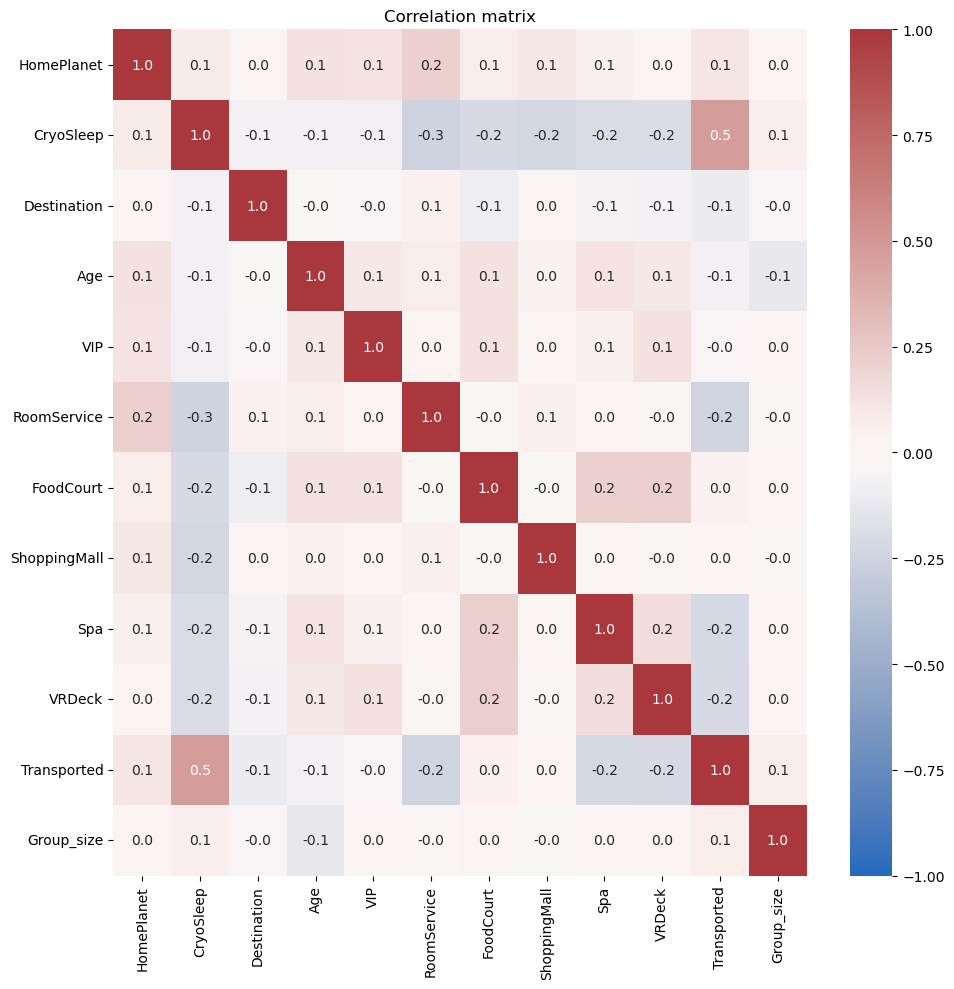

In [10]:
# ------------------------------------------- Further analyse categorical data 
 
# Plot correlation between the inputs, all numberical variables or categorical converted to numerical 

variables_to_drop = ['Name'] 
for variable in variables_to_drop:
    data = data.drop(variable, axis=1)
    data_test = data_test.drop(variable, axis=1)

def conf_matrix_plot(matrix, plot_name):
    fig = plt.figure(figsize = (10, 10))
    plt.title('Correlation matrix')
    mask = np.triu(matrix)
    ax = sn.heatmap(matrix, annot=True, fmt='.1f', vmin=-1, vmax=1, center= 0, cmap= 'vlag') # mask=mask)
    plt.tight_layout()
    plt.savefig('heatmap_'+plot_name+'.png')    
    
conf_matrix_plot(data.corr(), 'correlation_features')

# Look at unique values of the categorical data
all_cat_data = ['HomePlanet','Destination','CryoSleep']
for element in all_cat_data:
    print('Unique values for categorical data '+str(element)+' ='+str(data[element].nunique()))

# Look now at some tables to illustrate how each variable changes depending on the target variable 
# Start with categorical data with low multiplicity of unique values: HomePlanet, Destination, VIP, CryoSleep
simple_cat_data = ['HomePlanet','Destination','VIP', 'CryoSleep']
for element in simple_cat_data:
    print('\n Looking at categorical data '+str(element)+'\n')
    print(data_orig[[element,'Transported']].groupby(element).mean())


# Convert categorical Deck/Side data objects into numbers so we canlcualte their correlation and use it in the training
categorical_data_cabin = ['Deck','Side']
for cat_data_to_cnv in categorical_data_cabin:
    if cat_data_to_cnv in list(data.columns):
        print ("Handling now data category "+cat_data_to_cnv)
        data[cat_data_to_cnv] = pd.Categorical(data[cat_data_to_cnv]).codes
        data_test[cat_data_to_cnv] = pd.Categorical(data_test[cat_data_to_cnv]).codes

# Look at new categorical data defined from Cabin   
decomposed_cabin = ['Deck', 'Side']
for element in decomposed_cabin:
    print('\n Looking at categorical data '+str(element)+'\n')
    print(data_orig[[element,'Transported']].groupby(element).mean())
    print('Now looking at the correlation with the target label')
    print(data[element].corr(data['Transported']))
    
print('\n Looking at Group_size column and average values of the target label\n')
if 'Group_size' in list(data.columns):
    print(data[['Group_size','Transported']].groupby('Group_size').mean())

# Model training and final prediction

If you made it this far I wanted to say hello and thank you :) . 

Now I will define and train the model for the final prediction. The full code is here just for reference, as by default this notebook doesn't run a full hyperparameter scan. 

The model I decided to use is XGBoost implemented with a 5-fold cross validation strategy. I tried several configurations to test variations of input features, nan treatment, XGBoost model optimisation, etc. I calculated the classification accuracy with a small testing sample obtained by reserving 20% of the initial training dataset. For convenience I define a nominal model as follows:

1. Training features = ['HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Deck', 'Side', 'Group', 'Group_size', 'Gender', '#Vowels', '#Consonant']
2. Nans in numerical variables ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck'] are replaced with zeros. 
3. Rows with nans in the training features are removed
4. Outliers are kept 
5. Only a simple optimisation is performed on the for the max_depth parameter of the XGBoost model ('max_depth': [5,6,7])


In [11]:
# ------------------------------------------- Training with 5-fold cross validation 
    
X = data.drop('Transported', axis = 1)
y = data['Transported'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

model = XGBClassifier()

from sklearn.model_selection import GridSearchCV

parameters = {}

if dummy_optimisation:
    parameters = {
        'max_depth': [5,6,7] # Default is 6 
    }
else:
    parameters = {
        'eta': [0.05*i for i in range(2, 8)], # Default is 0.3
        'gamma': [0.05*i for i in range(0, 3)], # Default is 0 
        'max_depth': [4,5,6,7,8], # Default is 6 
        'max_leaves': [0,1,2] # Default is 0 
    }    
    
cv = GridSearchCV(model, parameters, cv=5)
cv.fit(X_train, y_train)

if feature_importance_plot: 
    fig = plt.figure(figsize = (4, 8))
    feat_imp = model.feature_importances_
    indices = np.argsort(feat_imp)
    plt.yticks(range(len(indices)), [X_train.columns[i] for i in indices])
    plt.barh(range(len(indices)), feat_imp[indices], color='r', align='center')
    plt.tight_layout()
    plt.savefig('feature_importance.png')

**Estimate the classification accuracy** using a reserved portion of the training dataset. 

In [12]:
y_pred = cv.best_estimator_.predict(X_test)
predictions = [value for value in y_pred]
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(list(data.columns))
print(cv.best_params_)

X_train = data.drop('Transported', axis = 1)
y_train = data['Transported'] 

Accuracy: 80.18%
['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Deck', 'Side', 'Group_size']
{'max_depth': 5}


# Final prediction and results of the optimisation

The results are as shown below. This table shows a number of possible options I tried out.  

Configuration | Classification accuracy [%] 
--- | --- 
Model 1: Nominal |             81.08
Model 2: Nominal, replace nans with averages (features other than in point 2) |             81.08
Model 3: Nominal + Outliers dropped |             80.50
Model 4: Nominal + reduced features set 1 (1)  |             80.18
Model 5: Nominal + reduced features set 2 (2) |             80.18
Model 6: Nominal + reduced features set 3 (3)|             80.68
Model 7: Nominal + reduced features set 2 + HP scan |   79.92           
Model 8: Nominal + reduced features set 3 + HP scan |   80.80

1. Set 1: ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Deck', 'Side', 'Group_size', 'Gender', 'Vowels', 'Consonant']

2. Set 2: ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Deck', 'Side', 'Group_size']

3. Set 3: ['HomePlanet', 'CryoSleep', 'Destination', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported', 'Deck', 'Side', 'Group_size']

The last two columns of the table above include two training configurations with a a detailed optimisation of the parameters of the model. 
The optimisation is performed by means of a grid search with the following options 

- 'eta': [0.05*i for i in range(2, 8)]
- 'gamma': [0.05*i for i in range(0, 3)]
- 'max_depth': [4,5,6,7,8]
- 'max_leaves': [0,1,2]

See the XGBoost manual for the definition of these parameters (https://xgboost.readthedocs.io/en/stable/).


# Submission, that's all folks !

For the submission in Kaggle used Model 8, refitted to the full training data. The final score on the Kaggle submission file is 0.80289, top 20% of the leaderboard. 

In [13]:
# ------------------------------------------- Final prediction

# Extract the hyperparameters manually based on the cv.best_params_ output and refit the model to the full training dataset  
model = XGBClassifier(eta= 0.1, gamma= 0.05, max_depth= 6, max_leaves= 0)
model.fit(X_train,y_train)

# Now calculate prediction on the full actual test set
y_pred_final = model.predict(data_test)
predictions = [True if value== 1 else False for value in y_pred_final]
data_submission = data_sub
data_submission['Transported']=pd.Series(predictions)
data_submission = data_submission[['PassengerId','Transported']]
data_submission.to_csv('submission.csv', index=False)